In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("keyushnisar/in-the-wild-currency-images")

print("Path to dataset files:", path)

100%|██████████| 9.41G/9.41G [01:53<00:00, 89.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/keyushnisar/in-the-wild-currency-images/versions/1


In [ ]:
import os
# File Path Like
#  /root/.cache/kagglehub/datasets/keyushnisar/in-the-wild-currency-images/versions/1/Currency_data/
data_path = "<filePath>"
print(os.listdir(data_path))


['INR', 'AED', 'THB', 'USD']


In [4]:
import tensorflow as tf
from tensorflow.keras import layers,Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Input,Dropout

In [5]:
datagen = ImageDataGenerator(rescale=1/.224,validation_split=0.2)

In [6]:
trainningdata=datagen.flow_from_directory(
    data_path,
    subset="training",
    target_size=(224, 224),
    seed=123,

)
validationdata=datagen.flow_from_directory(
    data_path,
    subset="validation",
    target_size=(224, 224),
    seed=123,
)

Found 5798 images belonging to 4 classes.
Found 1449 images belonging to 4 classes.


In [7]:
print(validationdata.class_indices)

{'AED': 0, 'INR': 1, 'THB': 2, 'USD': 3}


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Number of classes (auto from your dataset)
num_classes = len(trainningdata.class_indices)  # should be 4

# Data augmentation to handle "in the wild" variations
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="data_augmentation")

# Pretrained EfficientNetB0 as base
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,          # drop the top FC layers
    weights="imagenet",         # use ImageNet pretrained weights
    input_shape=(224, 224, 3)   # EfficientNet default input size
)

base_model.trainable = False   # freeze base layers initially

# Build model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)  # EfficientNet preprocessing

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',   # one-hot ke liye
    metrics=['accuracy']
)


In [11]:
history = model.fit(
    trainningdata,
    validation_data=validationdata,
    epochs=10)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 387s 2s/step - accuracy: 0.6462 - loss: 0.8528 - val_accuracy: 0.1912 - val_loss: 6.2539
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 360s 2s/step - accuracy: 0.8606 - loss: 0.3985 - val_accuracy: 0.1656 - val_loss: 8.9129
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 353s 2s/step - accuracy: 0.8827 - loss: 0.3446 - val_accuracy: 0.2098 - val_loss: 8.9328
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - accuracy: 0.8924 - loss: 0.3060 - val_accuracy: 0.2001 - val_loss: 9.0714
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 364s 2s/step - accuracy: 0.8985 - loss: 0.2818 - val_accuracy: 0.2133 - val_loss: 8.7867
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step - accuracy: 0.9060 - loss: 0.2752 - val_accuracy: 0.1774 - val_loss: 9.9008
Epoch 7/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 373s 2s/step - accuracy: 0.9043 - loss: 0.2663 - val_accuracy: 0.1919 - val_loss: 10.7902
Epoch 8/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step - accuracy: 0.9046 - loss: 0.2746 - val_acc

In [12]:
len(validationdata)

46

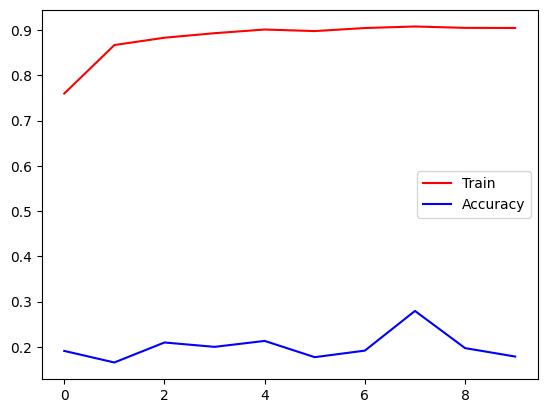

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color='red',label='Train')
plt.plot(history.history['val_accuracy'],color='blue',label='Accuracy')
plt.legend()
plt.show()

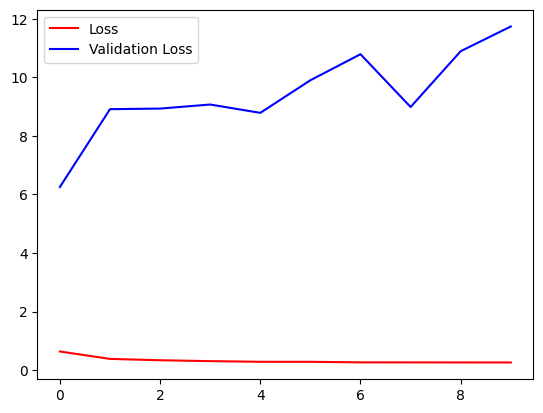

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],color='red',label='Loss')
plt.plot(history.history['val_loss'],color='blue',label='Validation Loss')
plt.legend()
plt.show()

In [15]:
import cv2

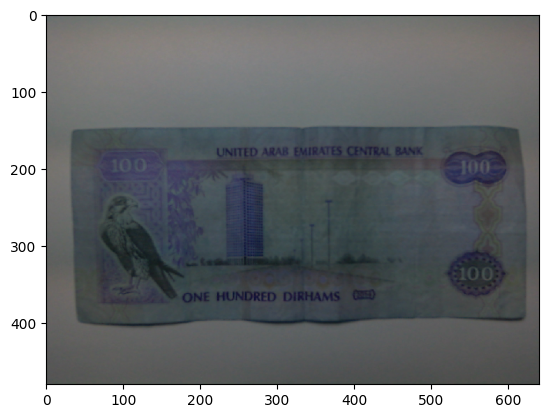

In [37]:
plt.imshow(input)

In [38]:
input.shape

(480, 640, 3)

In [47]:
# input = cv2.imread('/root/.cache/kagglehub/datasets/keyushnisar/in-the-wild-currency-images/versions/1/Currency_data/AED/AED100_back_0.png')
input = cv2.imread('/content/download.jpg')

In [48]:
input=cv2.resize(input,(224,224))

In [49]:
input2=input.reshape((1,224,224,3))

In [50]:
prediction = model.predict(input2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


In [51]:
print(prediction)

[[0.2192424  0.1945172  0.03031797 0.5559224 ]]


In [52]:
import numpy as np
predict_class = np.argmax(prediction)

In [53]:
print(predict_class)

3


In [54]:
classes = ['AED','INR','THB','USD']

In [55]:
print(classes[predict_class])

USD


In [56]:
loss, acc = model.evaluate(validationdata)

46/46 ━━━━━━━━━━━━━━━━━━━━ 44s 956ms/step - accuracy: 0.1778 - loss: 11.5376


In [58]:
print(f"Validation Accuracy: {acc*100:.2f}%")

Validation Accuracy: 17.87%
